<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Ashwini/Stock_prediction_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To import all required data files


In [23]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Method for getting data using Yahoo files

In [24]:

def getStockData(ticker: str, startYear: str, endYear: str):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=5y&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    data2 = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return data2

def toDatetime(t):
    return datetime.fromtimestamp(t)

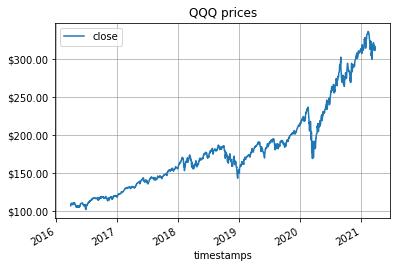

In [25]:
ticker = 'QQQ'
data2 = getStockData(ticker, "2013", "2019")

ax = data2.plot(x='timestamps', y=['close'], kind='line', title=ticker + ' prices')
vals = ax.get_yticks()
ax.set_yticklabels(['${:1.2f}'.format(x) for x in vals])
ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)
ax.set_axisbelow(True)
ax.grid(linestyle='-', linewidth='0.5', color='gray')

plt.show()

In [26]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 1260):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [27]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

In [28]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
38/38 [==============================] - 10s 96ms/step - loss: 0.0378
Epoch 2/15
38/38 [==============================] - 4s 98ms/step - loss: 0.0033
Epoch 3/15
38/38 [==============================] - 4s 101ms/step - loss: 0.0032
Epoch 4/15
38/38 [==============================] - 4s 101ms/step - loss: 0.0032
Epoch 5/15
38/38 [==============================] - 4s 102ms/step - loss: 0.0026
Epoch 6/15
38/38 [==============================] - 4s 103ms/step - loss: 0.0027
Epoch 7/15
38/38 [==============================] - 4s 105ms/step - loss: 0.0024
Epoch 8/15
38/38 [==============================] - 4s 105ms/step - loss: 0.0033
Epoch 9/15
38/38 [==============================] - 4s 104ms/step - loss: 0.0024
Epoch 10/15
38/38 [==============================] - 4s 104ms/step - loss: 0.0028
Epoch 11/15
38/38 [==============================] - 4s 104ms/step - loss: 0.0027
Epoch 12/15
38/38 [==============================] - 4s 105ms/step - loss: 0.0023
Epoch 13/15
38/38 [=======

In [36]:
testdataframe = ticker = 'QQQ'
testdata = getStockData(ticker, "2019", "2020")

def toDatetime(t):
    return datetime.fromtimestamp(t)

real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['open'], testdata['open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 235):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



In [37]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

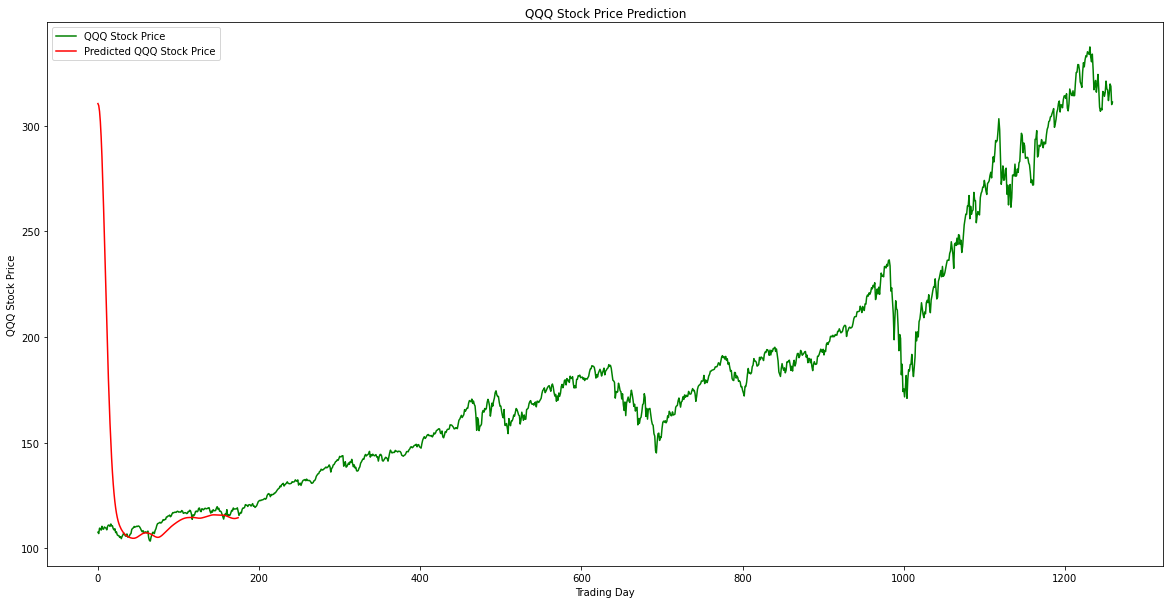

In [39]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'QQQ Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted QQQ Stock Price')
plt.title('QQQ Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('QQQ Stock Price')
plt.legend()
plt.show()